In [1]:
# SimPEG functionality
import simpeg.electromagnetics.time_domain as tdem
from simpeg.utils import plot_1d_layer_model, download, mkvc
from simpeg import (
    maps,
    data,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
)

# discretize functionality
from discretize import TensorMesh

# Basic Python functionality
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tarfile

mpl.rcParams.update({"font.size": 14})

In [2]:
import os

folder_path = '../data/'

csv_files = np.array([f for f in os.listdir(folder_path) if f.endswith('.csv')])
csv_files = np.sort(csv_files)[:-1]
print(csv_files)

['2301.csv' '2302.csv' '2303.csv' '2304.csv' '2305.csv' '2306.csv'
 '2307.csv' '2308.csv' '2309.csv' '2310.csv' '2311.csv' '2312.csv'
 '2313.csv' '2314.csv' '2315.csv' '2316.csv' '2317.csv' '2318.csv'
 '2319.csv' '2320.csv' '2321.csv' '2322.csv']


In [3]:
import pandas as pd

In [4]:
df_collar = pd.read_csv("../data/locations.csv")

../data/2322.csv, base freq:75 Hz


Text(0, 0.5, 'Voltage (mV/Am2)')

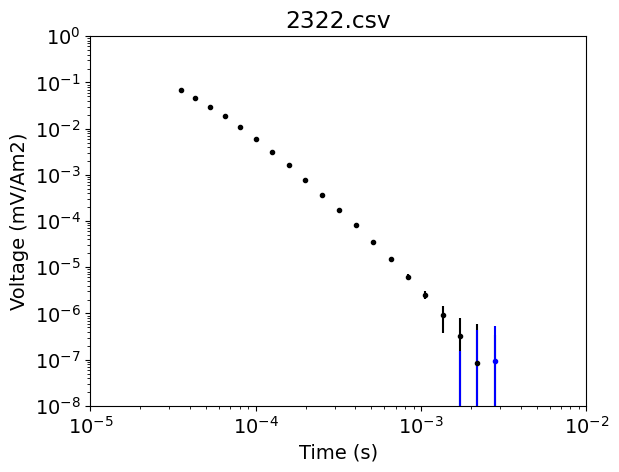

In [5]:
kk = 21
ii = 3
#colors = ['k', 'b']

df = pd.read_csv(folder_path+csv_files[kk])
df_group = df.groupby('f (Hz)')
base_freqs  = list(df_group.groups.keys())

base_freq = base_freqs[ii]
print (f"{folder_path+csv_files[kk]}, base freq:{base_freq:.0f} Hz")
df_tmp = df_group.get_group(base_freq)
i_start_time = 0
voltage = df_tmp['V (mV/Am2)'].values[i_start_time:]
noise = df_tmp['N (mV/Am2)'].values[i_start_time:]
times = df_tmp['Time (s)'].values[i_start_time:]
plt.errorbar(times, voltage, yerr=noise, marker='.', linestyle='None', color='k')
plt.errorbar(times, -voltage, yerr=noise, marker='.', linestyle='None', color='b')
plt.xscale('log')
plt.yscale('log')
# plt.loglog(times, noise, '.')
plt.ylim(1e-8, 1)
plt.xlim(1e-5, 1e-2)
plt.title(csv_files[kk])
plt.xlabel("Time (s)")
plt.ylabel("Voltage (mV/Am2)")

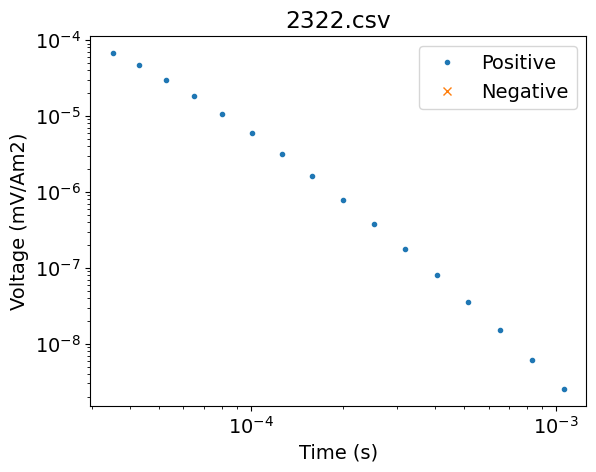

In [8]:
i_time_start = 0
i_time_end = 16
# Source properties
source_location = np.array([0.0, 0.0, 0.1]) # 0.1 m due to protem being on the ground
source_orientation = "z"  # "x", "y" or "z"
source_current = 1.0  # maximum on-time current
source_radius = 56.4  # source loop radius (chosen from an area of 100x100)

# Receiver properties
receiver_location = np.array([0.0, 0.0, 0.1])
receiver_orientation = "z"  # "x", "y" or "z"
#times = np.logspace(-5, -2, 31)  # time channels (s)

# Define receiver list. In our case, we have only a single receiver for each source.
# When simulating the response for multiple component and/or field orientations,
# the list consists of multiple receiver objects.
receiver_list = []
receiver_list.append(
    tdem.receivers.PointMagneticFluxTimeDerivative(
        receiver_location, times[i_time_start:i_time_end], orientation=receiver_orientation
    )
)
rampoff_time=5.1e-6 #taken from email thread
freq = 75.0       
T = 1/freq         
I_peak = 1.0       

# calculate times
t1 = -T/2
t2 = t1 + rampoff_time
t3 = -rampoff_time
t4 = 0.0

time_input_current=np.array([t1, t2, t3, t4])
input_current=np.array([0.0, I_peak, I_peak, 0.0])

# Define the source waveform. Here we define a unit step-off. The definition of
# other waveform types is covered in a separate tutorial.

stepoff_waveform = tdem.sources.PiecewiseLinearWaveform(times=time_input_current, currents=input_current)

# Define source list. In our case, we have only a single source.
source_list = [
    tdem.sources.CircularLoop(
        receiver_list=receiver_list,
        location=source_location,
        waveform=stepoff_waveform,
        current=source_current,
        radius=source_radius,
    )
]

# Define the survey
survey = tdem.Survey(source_list)
# 5% of the absolute value
uncertainties = (0.05 * np.abs(voltage*1e-3) * np.ones(np.shape(voltage*1e-3)))[i_time_start:i_time_end]
dobs = -voltage[i_time_start:i_time_end]*1e-3
data_object = data.Data(survey, dobs=dobs, standard_deviation=uncertainties)
plt.loglog(times[i_time_start:i_time_end], -data_object.dobs, '.', label="Positive")
plt.loglog(times[i_time_start:i_time_end], +data_object.dobs, 'x', label="Negative")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (mV/Am2)")
plt.title(csv_files[kk])
plt.legend()

In [9]:
len(times)

20

In [10]:
# estimated host conductivity (S/m)
estimated_conductivity = 0.001

# minimum diffusion distance
d_min = 1250 * np.sqrt(times.min() / estimated_conductivity)
print("MINIMUM DIFFUSION DISTANCE: {} m".format(d_min))

# maximum diffusion distance
d_max = 1250 * np.sqrt(times.max() / estimated_conductivity)
print("MAXIMUM DIFFUSION DISTANCE: {} m".format(d_max))

MINIMUM DIFFUSION DISTANCE: 234.68729194398233 m
MAXIMUM DIFFUSION DISTANCE: 2088.6598574205423 m


In [11]:
depth_min = 1.8  # top layer thickness
depth_max = 300.0  # depth to lowest layer
geometric_factor = 1.15  # rate of thickness increase

In [12]:
# Increase subsequent layer thicknesses by the geometric factors until
# it reaches the maximum layer depth.
layer_thicknesses = [depth_min]
while np.sum(layer_thicknesses) < depth_max:
    layer_thicknesses.append(geometric_factor * layer_thicknesses[-1])

n_layers = len(layer_thicknesses) + 1  # Number of layers
print(n_layers)


25


In [13]:
log_conductivity_map = maps.ExpMap(nP=n_layers)

In [14]:
simulation_L2 = tdem.Simulation1DLayered(
    survey=survey, thicknesses=layer_thicknesses, sigmaMap=log_conductivity_map
)

In [15]:
#n_layers_model = len(layer_thicknesses_model) + 1

In [16]:
source_area = 10000

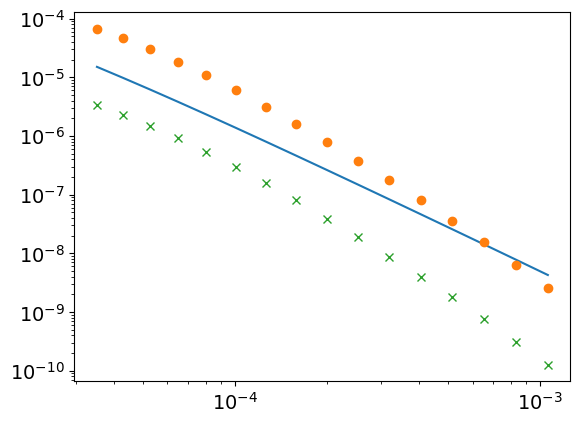

In [17]:
m0 = np.log(1./100 * np.ones(n_layers))
reference_conductivity=m0.copy()
dpred = simulation_L2.dpred(m0)
plt.loglog(times[i_time_start:i_time_end], -dpred)
plt.loglog(times[i_time_start:i_time_end], -dobs, 'o')
plt.loglog(times[i_time_start:i_time_end], uncertainties, 'x')
#print(n_layers)
#print(n_layers_model)

In [18]:
dmis_L2 = data_misfit.L2DataMisfit(simulation=simulation_L2, data=data_object)

In [19]:
# Define 1D cell widths
h = np.r_[layer_thicknesses, layer_thicknesses[-1]]
h = np.flipud(h)

# Create regularization mesh
regularization_mesh = TensorMesh([h], "N")
print(regularization_mesh)


  TensorMesh: 25 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     25       -376.31         -0.00      1.80     44.80    1.15




In [20]:
reg_L2 = regularization.WeightedLeastSquares(
    regularization_mesh,
    reference_model_in_smooth=False,
    alpha_s=1e-10,
    alpha_x=1,
)
opt_L2 = optimization.InexactGaussNewton(
    maxIter=15, maxIterLS=10, maxIterCG=50, tolCG=1e-3
)
inv_prob_L2 = inverse_problem.BaseInvProblem(dmis_L2, reg_L2, opt_L2)
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1)
beta_schedule = directives.BetaSchedule(coolingFactor=2.0, coolingRate=1)
target_misfit = directives.TargetMisfit(chifact=1.0)
save_dict = directives.SaveOutputDictEveryIteration()
directives_list_L2 = [starting_beta, beta_schedule, target_misfit, save_dict]
# Here we combine the inverse problem and the set of directives
inv_L2 = inversion.BaseInversion(inv_prob_L2, directives_list_L2)

# Run the inversion
recovered_model_L2 = inv_L2.run(m0)


Running inversion with SimPEG v0.24.0
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver SolverLU and no solver_opts.***
                    
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0


/opt/anaconda3/lib/python3.12/site-packages/pymatsolver/wrappers.py:81: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = fun(self.A, **self.kwargs)


   0  2.16e+02  2.64e+03  1.84e-31  2.64e+03    5.38e+02      0              
   1  1.08e+02  9.39e+02  1.45e-02  9.40e+02    6.09e+02      2              
   2  5.39e+01  8.74e+02  8.51e-02  8.78e+02    3.38e+03      0              
   3  2.70e+01  2.76e+01  1.32e-01  3.12e+01    3.86e+02      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 2.6445e+02
1 : |xc-x_last| = 1.5799e+00 <= tolX*(1+|x0|) = 2.4026e+00
0 : |proj(x-g)-x|    = 3.8587e+02 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 3.8587e+02 <= 1e3*eps       = 1.0000e-02
0 : maxIter   =      15    <= iter          =      4
------------------------- DONE! -------------------------


In [21]:
inv_prob_L2.phi_d

3.005175623821843

In [22]:
survey.nD

16

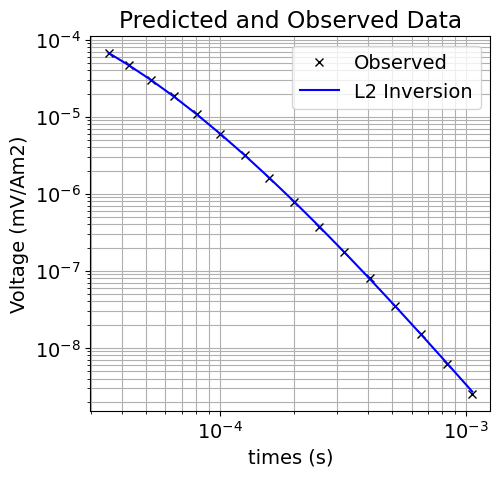

In [23]:
iterations = list(save_dict.outDict.keys())
iteration = len(iterations)
m_rec = save_dict.outDict[iteration]['m']
sigma_rec = log_conductivity_map * m_rec
dpred_rec = save_dict.outDict[iteration]['dpred']
fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_axes([0.15, 0.15, 0.8, 0.75])
ax1.loglog(times[i_time_start:i_time_end], np.abs(dobs), "kx")
ax1.loglog(times[i_time_start:i_time_end], np.abs(dpred_rec), "b-")
ax1.grid(which="both")
ax1.set_xlabel("times (s)")
ax1.set_ylabel("Voltage (mV/Am2)")
ax1.set_title("Predicted and Observed Data")
ax1.legend(["Observed", "L2 Inversion"], loc="upper right")
plt.show()

In [24]:
np.save(f'm_rec_{kk+1}m_rec.npy', m_rec)

Text(0.5, 0, 'Resistivity (Ω·m)')

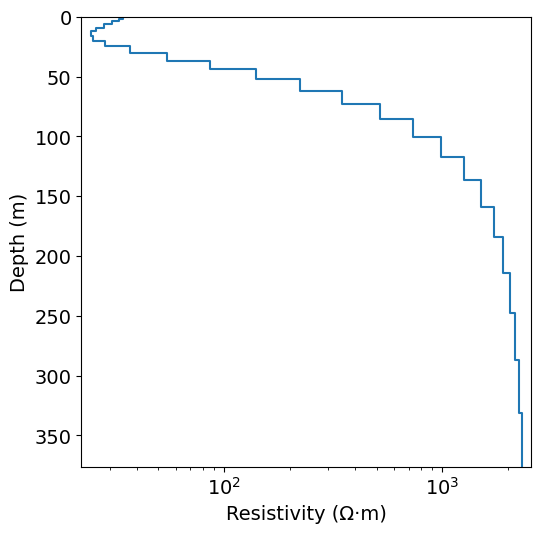

In [25]:
ax = plot_1d_layer_model(layer_thicknesses, 1./sigma_rec)
ax.set_xlabel("Resistivity (Ω·m)")


In [200]:
i_time_start = 4
i_time_end_13 = 13
i_time_end_16 = 16


In [201]:
# --- RECEIVERS FOR 4–13 AND 4–16 --- #
receiver_list_13 = [
    tdem.receivers.PointMagneticFluxTimeDerivative(
        receiver_location,
        times[i_time_start:i_time_end_13],
        orientation=receiver_orientation,
    )
]

receiver_list_16 = [
    tdem.receivers.PointMagneticFluxTimeDerivative(
        receiver_location,
        times[i_time_start:i_time_end_16],
        orientation=receiver_orientation,
    )
]

# Define sources (same waveform, current, radius, location; different receivers)
source_13 = tdem.sources.CircularLoop(
    receiver_list=receiver_list_13,
    location=source_location,
    waveform=stepoff_waveform,
    current=source_current,
    radius=source_radius,
)

source_16 = tdem.sources.CircularLoop(
    receiver_list=receiver_list_16,
    location=source_location,
    waveform=stepoff_waveform,
    current=source_current,
    radius=source_radius,
)

survey_13 = tdem.Survey([source_13])
survey_16 = tdem.Survey([source_16])

# --- DATA OBJECTS FOR 4–13 AND 4–16 --- #
dobs_13 = -voltage[i_time_start:i_time_end_13] * 1e-3
uncertainties_13 = (
    0.05 * np.abs(voltage[i_time_start:i_time_end_13] * 1e-3)
)

dobs_16 = -voltage[i_time_start:i_time_end_16] * 1e-3
uncertainties_16 = (
    0.05 * np.abs(voltage[i_time_start:i_time_end_16] * 1e-3)
)

data_object_13 = data.Data(
    survey_13, dobs=dobs_13, standard_deviation=uncertainties_13
)
data_object_16 = data.Data(
    survey_16, dobs=dobs_16, standard_deviation=uncertainties_16
)


In [202]:
# --- SIMULATIONS --- #
simulation_L2_13 = tdem.Simulation1DLayered(
    survey=survey_13,
    thicknesses=layer_thicknesses,
    sigmaMap=log_conductivity_map,
)

simulation_L2_16 = tdem.Simulation1DLayered(
    survey=survey_16,
    thicknesses=layer_thicknesses,
    sigmaMap=log_conductivity_map,
)

# starting model
m0 = np.log(1.0 / 100 * np.ones(n_layers))

# --- DATA MISFITS --- #
dmis_L2_13 = data_misfit.L2DataMisfit(
    simulation=simulation_L2_13, data=data_object_13
)
dmis_L2_16 = data_misfit.L2DataMisfit(
    simulation=simulation_L2_16, data=data_object_16
)

# --- REGULARIZATION (same mesh, different instances just to be safe) --- #
reg_L2_13 = regularization.WeightedLeastSquares(
    regularization_mesh,
    reference_model_in_smooth=False,
    alpha_s=1e-10,
    alpha_x=1,
)
reg_L2_16 = regularization.WeightedLeastSquares(
    regularization_mesh,
    reference_model_in_smooth=False,
    alpha_s=1e-10,
    alpha_x=1,
)

# --- OPTIMIZERS --- #
opt_L2_13 = optimization.InexactGaussNewton(
    maxIter=15, maxIterLS=10, maxIterCG=50, tolCG=1e-3
)
opt_L2_16 = optimization.InexactGaussNewton(
    maxIter=15, maxIterLS=10, maxIterCG=50, tolCG=1e-3
)

# --- INVERSE PROBLEMS --- #
inv_prob_L2_13 = inverse_problem.BaseInvProblem(
    dmis_L2_13, reg_L2_13, opt_L2_13
)
inv_prob_L2_16 = inverse_problem.BaseInvProblem(
    dmis_L2_16, reg_L2_16, opt_L2_16
)

# --- DIRECTIVES (one set per inversion) --- #
start_beta_13 = directives.BetaEstimate_ByEig(beta0_ratio=1)
beta_schedule_13 = directives.BetaSchedule(coolingFactor=2.0, coolingRate=1)
target_misfit_13 = directives.TargetMisfit(chifact=1.0)
save_dict_13 = directives.SaveOutputDictEveryIteration()

directives_list_13 = [
    start_beta_13,
    beta_schedule_13,
    target_misfit_13,
    save_dict_13,
]

start_beta_16 = directives.BetaEstimate_ByEig(beta0_ratio=1)
beta_schedule_16 = directives.BetaSchedule(coolingFactor=2.0, coolingRate=1)
target_misfit_16 = directives.TargetMisfit(chifact=1.0)
save_dict_16 = directives.SaveOutputDictEveryIteration()

directives_list_16 = [
    start_beta_16,
    beta_schedule_16,
    target_misfit_16,
    save_dict_16,
]

inv_L2_13 = inversion.BaseInversion(inv_prob_L2_13, directives_list_13)
inv_L2_16 = inversion.BaseInversion(inv_prob_L2_16, directives_list_16)

# --- RUN BOTH INVERSIONS --- #
m_rec_13 = inv_L2_13.run(m0)
m_rec_16 = inv_L2_16.run(m0)

sigma_rec_13 = log_conductivity_map * m_rec_13
sigma_rec_16 = log_conductivity_map * m_rec_16



Running inversion with SimPEG v0.24.0
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver SolverLU and no solver_opts.***
                    
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0


/opt/anaconda3/lib/python3.12/site-packages/pymatsolver/wrappers.py:81: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = fun(self.A, **self.kwargs)


   0  4.05e+03  2.61e+04  1.84e-31  2.61e+04    2.50e+04      0              
   1  2.02e+03  2.30e+03  3.42e-03  2.30e+03    3.33e+03      0              
   2  1.01e+03  1.68e+02  1.13e-02  1.80e+02    5.32e+02      0   Skip BFGS  
   3  5.06e+02  3.90e+01  1.96e-02  4.89e+01    1.78e+02      0   Skip BFGS  
   4  2.53e+02  2.64e+01  2.75e-02  3.34e+01    1.28e+02      0   Skip BFGS  
   5  1.26e+02  2.19e+01  3.42e-02  2.63e+01    1.09e+02      1   Skip BFGS  
   6  6.32e+01  1.96e+01  4.07e-02  2.22e+01    1.10e+02      2   Skip BFGS  
   7  3.16e+01  1.83e+01  5.16e-02  2.00e+01    1.46e+02      2   Skip BFGS  
   8  1.58e+01  1.73e+01  5.89e-02  1.82e+01    1.56e+02      3   Skip BFGS  
   9  7.90e+00  1.66e+01  6.38e-02  1.71e+01    1.61e+02      4   Skip BFGS  
  10  3.95e+00  1.64e+01  7.08e-02  1.67e+01    1.79e+02      4   Skip BFGS  
  11  1.98e+00  1.61e+01  7.60e-02  1.63e+01    1.88e+02      5   Skip BFGS  
  12  9.88e-01  1.59e+01  7.96e-02  1.60e+01    1.91e+02      6 

In [227]:
#save_dict_13 = directives.SaveOutputDictEveryIteration()
#save_dict_16 = directives.SaveOutputDictEveryIteration()
#directives_list_13 = [start_beta_13, beta_schedule_13, target_misfit_13, save_dict_13]
#directives_list_16 = [start_beta_16, beta_schedule_16, target_misfit_16, save_dict_16]
#iterations = list(save_dict.outDict.keys())
iterations_13 = list(save_dict_13.outDict.keys())
iteration_13 = 15    # last iteration, safer than forcing 15

m_rec_13 = save_dict_13.outDict[iteration_13]["m"]
sigma_rec_13 = log_conductivity_map * m_rec_13
dpred_rec_13 = save_dict_13.outDict[iteration_13]["dpred"]

iterations_16 = list(save_dict_16.outDict.keys())
iteration_16 = 15

m_rec_16 = save_dict_16.outDict[iteration_16]["m"]
sigma_rec_16 = log_conductivity_map * m_rec_16
dpred_rec_16 = save_dict_16.outDict[iteration_16]["dpred"]


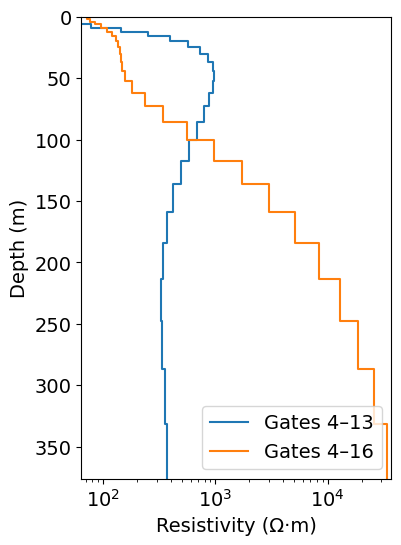

In [228]:
fig, ax = plt.subplots(1, 1, figsize=(4, 6))

ax = plot_1d_layer_model(
    layer_thicknesses,
    1.0 / sigma_rec_13,
    ax=ax,
    label="Gates 4–13",
)
ax = plot_1d_layer_model(
    layer_thicknesses,
    1.0 / sigma_rec_16,
    ax=ax,
    label="Gates 4–16",
)

ax.set_xscale("log")
ax.set_xlabel("Resistivity (Ω·m)")
ax.set_ylabel("Depth (m)")
#ax.set_title("Recovered 1D Models for Different Time Gates")
ax.legend()
#plt.gca().invert_yaxis()  # if not already flipped by helper
plt.show()
